<a href="https://colab.research.google.com/github/fabiobento/multi-view-geometry/blob/master/Epipolar_lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install opencv-python==3.4.2.16

!pip install opencv-contrib-python==3.4.2.16

Epi lines on left image


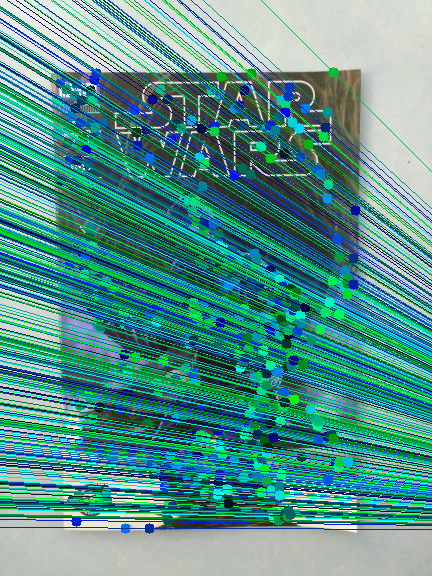


Feature points on right image


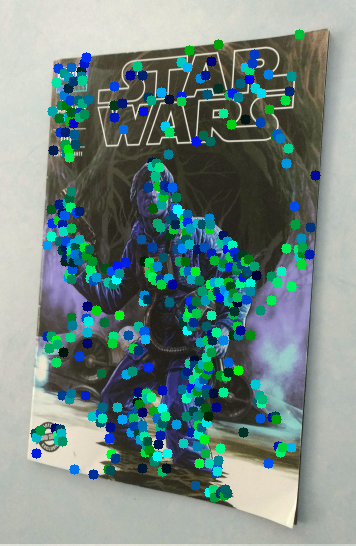


Epi lines on right image


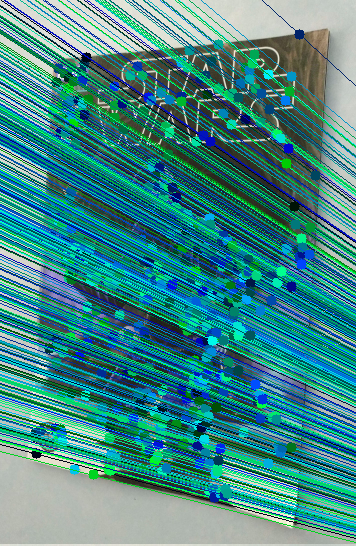


Feature points on left image


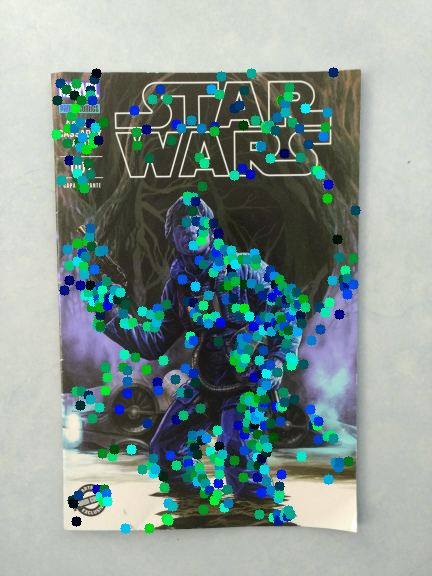

In [25]:
# import the necessary packages
import cv2
import numpy as np
from urllib.request import urlopen
import cv2
from google.colab.patches import cv2_imshow
 
def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, readFlag)

    # return the image
    return image


def draw_lines(img_left, img_right, lines, pts_left, pts_right):
    h,w = img_left.shape[:-1]
    img_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2BGR)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_RGB2BGR)

    for line, pt_left, pt_right in zip(lines, pts_left, pts_right):
        x_start,y_start = map(int, [0, -line[2]/line[1] ])
        x_end,y_end = map(int, [w, -(line[2]+line[0]*w)/line[1] ])
        color = tuple(np.random.randint(0,255,2).tolist())
        cv2.line(img_left, (x_start,y_start), (x_end,y_end), color,1)
        cv2.circle(img_left, tuple(pt_left), 5, color, -1)
        cv2.circle(img_right, tuple(pt_right), 5, color, -1)

    return img_left, img_right

def get_descriptors(gray_image, feature_type):
    if feature_type == 'surf':
        feature_extractor = cv2.xfeatures2d.SURF_create()
        #feature_extractor = cv2.SURF()
    elif feature_type == 'sift':
        feature_extractor = cv2.xfeatures2d.SIFT_create()
        #        feature_extractor = cv2.SIFT()
    else:
        raise TypeError("Invalid feature type; should be either 'surf' or 'sift'")

    keypoints, descriptors = feature_extractor.detectAndCompute(gray_image,None)
    #feature_extractor.detectAndCompute(gray_image, None)
    return keypoints, descriptors


left_image = "https://raw.githubusercontent.com/fabiobento/multi-view-geometry/master/data/stereo/comicsStarWars01.jpg?token=AFCHXJIZESHUCIXYXQSS7VK42QXCY"  
right_image = "https://raw.githubusercontent.com/fabiobento/multi-view-geometry/master/data/stereo/comicsStarWars02.jpg?token=AFCHXJPRSHOCKESRVAFK74C42QXMO"
img_left = url_to_image(left_image)
img_right = url_to_image(right_image)

feature_type = 'sift'
if feature_type not in ['sift', 'surf']:
    raise TypeError("Invalid feature type; has to be either 'sift' or 'surf'")

scaling_factor = 0.5
img_left = cv2.resize(img_left, None, fx=scaling_factor,fy=scaling_factor, interpolation=cv2.INTER_AREA)
img_right = cv2.resize(img_right, None, fx=scaling_factor,fy=scaling_factor, interpolation=cv2.INTER_AREA)

kps_left, des_left = get_descriptors(img_left, feature_type)
kps_right, des_right = get_descriptors(img_right, feature_type)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

# Get the matches based on the descriptors
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_left, des_right, k=2)

pts_left_image = []
pts_right_image = []

# ratio test to retain only the good matches
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        pts_left_image.append(kps_left[m.queryIdx].pt)
        pts_right_image.append(kps_right[m.trainIdx].pt)

pts_left_image = np.float32(pts_left_image)
pts_right_image = np.float32(pts_right_image)
F, mask = cv2.findFundamentalMat(pts_left_image, pts_right_image, cv2.FM_LMEDS)

# Selecting only the inliers
pts_left_image = pts_left_image[mask.ravel()==1]
pts_right_image = pts_right_image[mask.ravel()==1]

# Drawing the lines on left image and the corresponding feature points on the right image
lines1 = cv2.computeCorrespondEpilines (pts_right_image.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img_left_lines, img_right_pts = draw_lines(img_left, img_right, lines1, pts_left_image, pts_right_image)

# Drawing the lines on right image and the corresponding feature points on the left image
lines2 = cv2.computeCorrespondEpilines (pts_left_image.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img_right_lines, img_left_pts = draw_lines(img_right, img_left, lines2, pts_right_image, pts_left_image)

print('Epi lines on left image')
cv2_imshow(img_left_lines)
print('\nFeature points on right image')
cv2_imshow(img_right_pts)
print('\nEpi lines on right image')
cv2_imshow(img_right_lines)
print('\nFeature points on left image')
cv2_imshow(img_left_pts)
